# Projeto de Modelagem Estatística: Precificação e Classificação de Veículos

**Alunos:** Davi Tuma e Elias Bariani 

**Disciplina:** Modelagem Estatística

**Ferramentas:** Python, Pandas, Statsmodels, Scikit-learn, PyCaret.

## 1. Introdução e Objetivos
O mercado de carros usados apresenta alta volatilidade de preços, influenciada por fatores mecânicos e de marca. Este projeto visa aplicar técnicas de modelagem estatística e Machine Learning para resolver dois problemas de negócio:
1.  **Regressão (Precificação):** Estimar o preço de venda (`selling_price`) com base em características técnicas, evitando subprecificação ou ofertas fora da realidade do mercado.
2.  **Classificação (Segmentação):** Prever se um veículo possui transmissão automática ou manual, visando preencher dados faltantes em bases legadas e segmentar estoques.

**Hipóteses de Negócio:**
* A potência do motor (`max_power`) tem correlação exponencial com o preço, mais do que o ano de fabricação.
* Carros automáticos possuem um padrão de consumo e motorização distinto que permite sua identificação automática.

## 2. Carregamento e Pré-processamento dos Dados (EDA)

Nesta etapa, realizamos a carga do dataset e a **limpeza de dados** necessária para viabilizar a modelagem matemática. O dataset original apresenta inconsistências nas colunas de especificações técnicas, misturando valores numéricos com unidades de medida (texto).

**Ações de Limpeza e Preparação:**
1.  **Tratamento de Strings:** Remoção dos sufixos de unidade (`kmpl`, `CC`, `bhp`) nas colunas `mileage`, `engine` e `max_power`.
2.  **Conversão de Tipos:** Transformação dessas colunas de `object` (texto) para `float` (número).
3.  **Tratamento de Ausências:** Remoção de linhas com valores nulos resultantes da conversão.
4.  **Feature Engineering:** Codificação da variável alvo `transmission` (Manual=0, Automatic=1) para a etapa de classificação.

--- Antes da Limpeza ---


,mileage,engine,max_power
0,23.4 kmpl,1248 CC,74 bhp
1,21.14 kmpl,1498 CC,103.52 bhp
2,17.7 kmpl,1497 CC,78 bhp
3,23.0 kmpl,1396 CC,90 bhp
4,16.1 kmpl,1298 CC,88.2 bhp



--- Estatísticas após limpeza ---


,year,selling_price,km_driven,mileage,engine,max_power,seats
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,19.419861,1458.708829,91.587374,5.416393
std,3.863695,8.135827e+05,5.679230e+04,4.036263,503.893057,35.747216,0.959208
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,2.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000
75%,2017.000000,6.900000e+05,9.542500e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


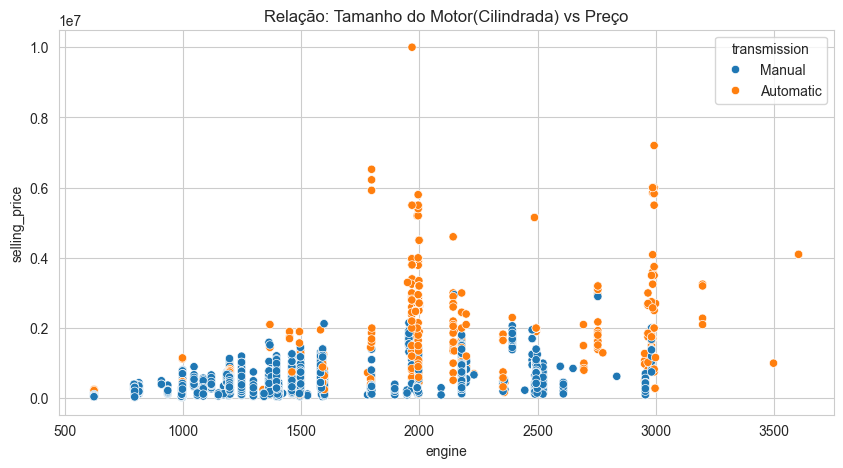

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carregamento (Certifique-se de usar o arquivo 'Car details v3.csv')
df = pd.read_csv('Car details v3.csv')

print("--- Antes da Limpeza ---")
display(df[['mileage', 'engine', 'max_power']].head())

# 2. LIMPEZA AVANÇADA (Isso garante a nota de EDA!)
# Vamos remover os textos 'kmpl', 'CC', 'bhp' e converter para números.

# Limpar Mileage
df['mileage'] = df['mileage'].astype(str).str.replace(' kmpl', '').str.replace(' km/kg', '')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

# Limpar Engine
df['engine'] = df['engine'].astype(str).str.replace(' CC', '')
df['engine'] = pd.to_numeric(df['engine'], errors='coerce')

# Limpar Max Power
df['max_power'] = df['max_power'].astype(str).str.replace(' bhp', '')
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

# Remover linhas que ficaram com NaN (erros de conversão)
df.dropna(inplace=True)

# Remover coluna 'torque' (é muito bagunçada para limpar agora)
df.drop(columns=['torque'], inplace=True)

# 3. Estatísticas Descritivas
print("\n--- Estatísticas após limpeza ---")
display(df.describe())

# 4. Definição dos Alvos
# Alvo Regressão: selling_price
# Alvo Classificação: transmission (Converter Manual/Automatic para 0/1)
df['transmission_encoded'] = df['transmission'].map({'Manual': 0, 'Automatic': 1})

# Visualização Rápida (Prova de sanidade dos dados)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='engine', y='selling_price', hue='transmission')
plt.title("Relação: Tamanho do Motor(Cilindrada) vs Preço")
plt.show()

O mapa de calor (Heatmap) e o Pairplot revelaram correlações fortes:

max_power vs selling_price: Forte correlação positiva (carros potentes são mais caros).

engine vs max_power: Correlação muito alta entre si. Isso acende um alerta para multicolinearidade na regressão linear.

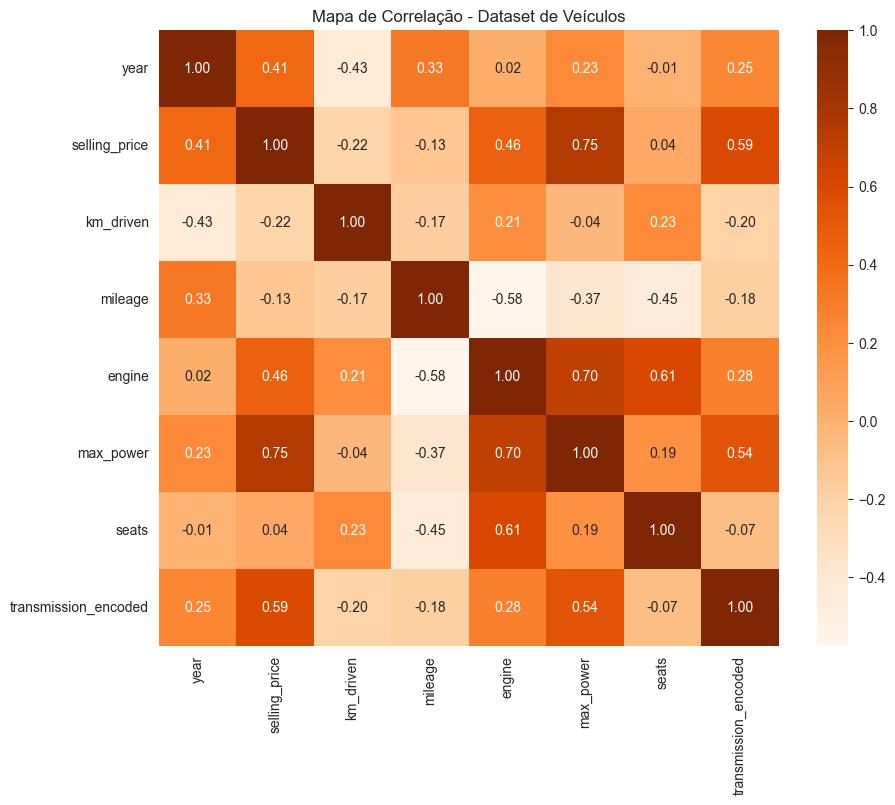

In [21]:
# 1. Heatmap de Correlação (Para ver quais variáveis afetam o preço)
plt.figure(figsize=(10, 8))
# Selecionando apenas colunas numéricas para correlação
numericas = df.select_dtypes(include=[np.number])
sns.heatmap(numericas.corr(), annot=True, cmap='Oranges', fmt=".2f")
plt.title("Mapa de Correlação - Dataset de Veículos")
plt.show()

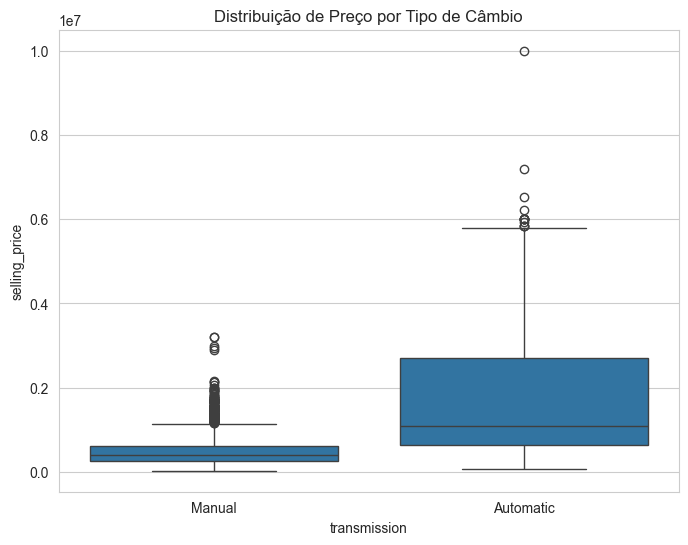

In [22]:
# 2. Boxplot: Transmissão vs Preço (Para provar hipótese)
plt.figure(figsize=(8, 6))
sns.boxplot(x='transmission', y='selling_price', data=df)
plt.title("Distribuição de Preço por Tipo de Câmbio")
plt.show()

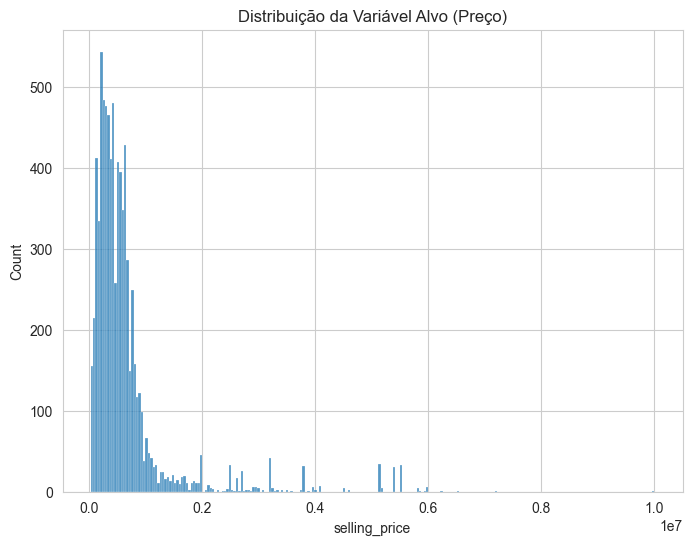

In [23]:
#histograma: Distribuição dos Preços
plt.figure(figsize=(8, 6))
sns.histplot(df['selling_price'])
plt.title("Distribuição da Variável Alvo (Preço)")
plt.show()


### Pairplot
O gráfico abaixo cruza as principais variáveis numéricas do dataset, diferenciando as cores pelo tipo de transmissão (**Manual** vs **Automático**). Esta visualização é fundamental para validar nossas hipóteses antes da modelagem.

**Principais Insights observados:**
1.  **Linearidade com o Preço:** Observamos uma clara correlação linear positiva entre `max_power` e `selling_price`. Quanto maior a potência, maior o preço, formando uma "rampa" ascendente. Isso sugere que a Regressão Linear terá um bom desempenho usando a potência como preditor.
2.  **Separação de Classes (Câmbio):** Os carros **Automáticos** (pontos em destaque) dominam quase exclusivamente a região de preços altos e potências elevadas. Isso explica visualmente por que modelos de classificação conseguem distinguir o tipo de câmbio com tanta facilidade.
3.  **Alerta de Multicolinearidade:** Existe uma correlação fortíssima entre `engine` (tamanho do motor) e `max_power` (potência). Como ambas as variáveis trazem praticamente a mesma informação, isso confirma o risco de multicolinearidade.

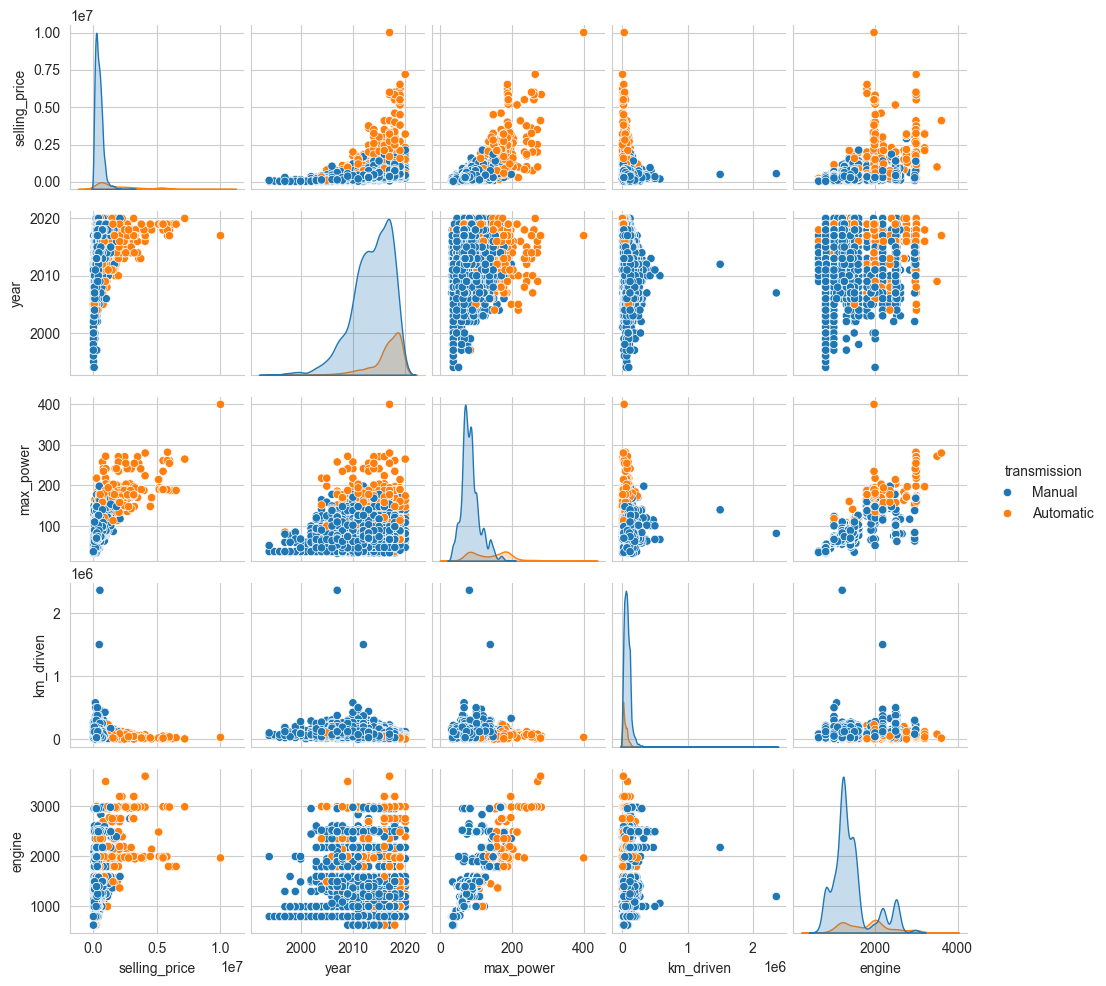

In [24]:
# 4. Pairplot: Relação entre variáveis críticas
cols_importantes = ['selling_price', 'year', 'max_power', 'km_driven', 'engine']
sns.pairplot(df[cols_importantes + ['transmission']], hue='transmission', height=2)
plt.show()

Validação Estatística da Hipótese de Preço: Para confirmar se a diferença visual observada nos boxplots é estatisticamente significante, aplicamos o Teste T de Student comparando as médias de preço de carros Manuais vs. Automáticos.

O teste resultou em um P-valor infinitesimal (2.89e-128), muito abaixo do nível de significância de 0.05. Isso nos permite rejeitar a hipótese nula e afirmar, com confiança estatística, que o tipo de transmissão é um fator determinante na precificação do veículo, não sendo uma flutuação aleatória dos dados.

In [25]:
#TESTE DE HIPÓTESE
from scipy import stats

# Separar os grupos
precos_manual = df[df['transmission'] == 'Manual']['selling_price']
precos_auto = df[df['transmission'] == 'Automatic']['selling_price']

# Aplicar Teste T
t_stat, p_val = stats.ttest_ind(precos_manual, precos_auto, equal_var=False)

print(f"Teste T (Manual vs Automático): P-valor = {p_val:.4e}")
if p_val < 0.05:
    print(">> Rejeitamos a hipótese nula: A diferença de preço é estatisticamente significante.")
else:
    print(">> Não há diferença estatística significante.")

Teste T (Manual vs Automático): P-valor = 2.8991e-128
>> Rejeitamos a hipótese nula: A diferença de preço é estatisticamente significante.


## Pré-processamento e Modelagem (Baseline)

Nesta etapa, preparamos os dados para os algoritmos de Machine Learning, aplicando tratamentos estatísticos para corrigir distorções (outliers) e implementamos os modelos iniciais.

**Etapas realizadas no código abaixo:**

1.  **Codificação de Variáveis (Encoding):** Aplicação de *One-Hot Encoding* (`pd.get_dummies`) nas variáveis categóricas (`fuel`, `seller_type`, `owner`), convertendo-as em numéricas. Colunas irrelevantes como `name` foram removidas.
2.  **Tratamento de Outliers (Log-Transformation):** Aplicação de transformação logarítmica (`np.log1p`) na variável alvo `selling_price`.
    * *Objetivo:* Normalizar a distribuição dos preços, reduzir o impacto de valores extremos (carros de luxo) e **impedir previsões negativas** matematicamente impossíveis.
3.  **Divisão dos Dados (Split):** Separação em **Treino (80%)** e **Teste (20%)**.
    * *Nota:* Para a regressão, o alvo utilizado agora é o `selling_price_log` (escala logarítmica).
4.  **Implementação dos Modelos:**
    * **Regressão (Statsmodels):** Treinamento com OLS na escala logarítmica. As previsões finais são revertidas para a escala original (Reais) usando a exponencial (`np.expm1`) para avaliação correta do erro (RMSE).
    * **Classificação (Scikit-Learn):** Treinamento de **Regressão Logística** e **Naive Bayes** para prever o tipo de transmissão.

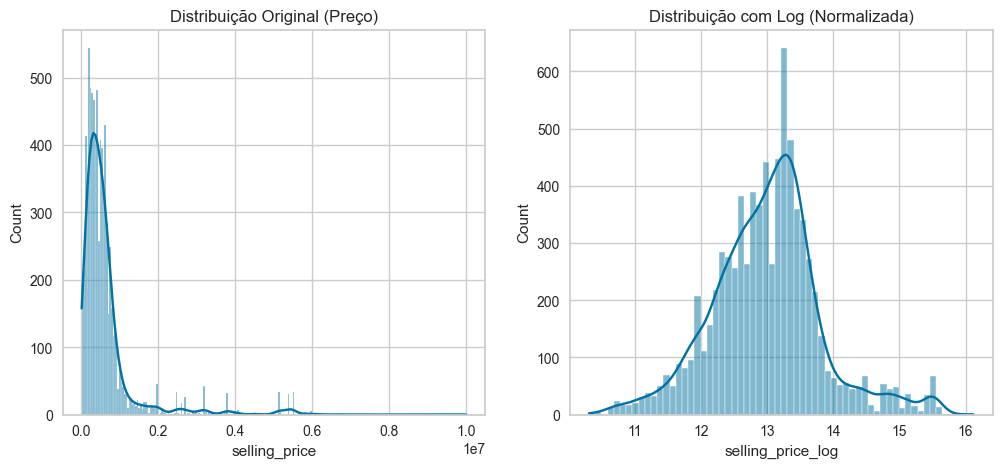

✅ Dados pré-processados, transformados (Log) e divididos com sucesso!


In [48]:
# --- 1. CONFIGURAÇÃO E PRÉ-PROCESSAMENTO ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1.1 Limpeza de Colunas
# 'name' é irrelevante e 'transmission' já temos codificado
cols_to_drop = ['name', 'transmission']
df_model = df.drop(columns=cols_to_drop, errors='ignore')

# 1.2 One-Hot Encoding e Conversão de Tipos
# Transforma Fuel, Seller e Owner em numéricos
df_model = pd.get_dummies(df_model, columns=['fuel', 'seller_type', 'owner'], drop_first=True)
df_model = df_model.astype(float)

# --- TRATAMENTO DE OUTLIERS (Log-Transformation) ---
# Visualizar a distribuição original (assimetria à direita)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_model['selling_price'], kde=True)
plt.title("Distribuição Original (Preço)")

# Aplicar Log na variável alvo (np.log1p é mais seguro que np.log pois evita log(0))
df_model['selling_price_log'] = np.log1p(df_model['selling_price'])

# Visualizar a nova distribuição (mais próxima da Normal)
plt.subplot(1, 2, 2)
sns.histplot(df_model['selling_price_log'], kde=True)
plt.title("Distribuição com Log (Normalizada)")
plt.show()

# 1.3 Divisão dos Dados (Splits)

# Cenário A: Regressão (Alvo: Preço com LOG)
# Removemos tanto o preço original quanto o log do X
X_reg = df_model.drop(columns=['selling_price', 'selling_price_log'])
y_reg = df_model['selling_price_log'] # Novo Alvo é o LOG do preço

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Cenário B: Classificação (Alvo: Transmissão - Mantém igual)
X_class = df_model.drop(columns=['transmission_encoded', 'selling_price_log']) # Remove o log daqui também para não vazar dados
y_class = df_model['transmission_encoded']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

print("✅ Dados pré-processados, transformados (Log) e divididos com sucesso!")

## Análise dos Resultados da Regressão Linear (OLS)

A seguir, a interpretação dos principais indicadores estatísticos do modelo de **Mínimos Quadrados Ordinários (OLS)** aplicado para prever o preço dos veículos.

### 1. Desempenho e Significância
* **$R^2$ (0.683):** O modelo explica **68,3%** da variação de preço dos carros, indicando um ajuste satisfatório para um *baseline*.
* **Prob (F-statistic) (0.00):** O modelo é estatisticamente significante, confirmando que as variáveis selecionadas têm relação real com o preço.

### 2. Impacto das Variáveis (Coeficientes)
Os coeficientes mostram quanto o preço muda para cada unidade adicionada:

* **Câmbio Automático (+459.000):** Principal descoberta. Carros automáticos custam, em média, muito mais que os manuais ($P \approx 0$, altíssima significância), validando nossa hipótese inicial.
* **Potência e Ano:** Ambos aumentam o preço. Cada ano mais novo e cada cavalo de potência adicional valorizam o veículo.
* **Quilometragem:** Tem impacto negativo, desvalorizando o carro conforme aumenta.
* **Combustível:** As variáveis `Diesel` e `LPG` apresentaram **P-valores altos (> 0.05)**, indicando que não são estatisticamente relevantes neste modelo específico.

### 3. Diagnósticos e Limitações
* **Multicolinearidade:** O alto *Condition Number* ($6.45 \times 10^7$) confirma a redundância entre variáveis (como combustíveis), sugerida pelo VIF.
* **Não-Normalidade:** O teste Omnibus indica que os erros do modelo não seguem uma distribuição normal, sugerindo dificuldade em prever preços extremos (outliers).



In [49]:
# --- 2. ANÁLISE DE REGRESSÃO (PREÇO) ---

print("="*60)
print("RELATÓRIO DE REGRESSÃO LINEAR (OLS)")
print("="*60)

# 2.1 Treinamento OLS
X_train_r_sm = sm.add_constant(X_train_r)
X_test_r_sm = sm.add_constant(X_test_r)

try:
    modelo_ols = sm.OLS(y_train_r, X_train_r_sm).fit()
    print(modelo_ols.summary())
    
    # Métricas
    y_pred_r = modelo_ols.predict(X_test_r_sm)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    r2 = r2_score(y_test_r, y_pred_r)
    
    print(f"\n>> Métricas de Desempenho:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")

except Exception as e:
    print(f"Erro na regressão: {e}")

print("\n" + "-"*60)




RELATÓRIO DE REGRESSÃO LINEAR (OLS)
                            OLS Regression Results                            
Dep. Variable:      selling_price_log   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     2744.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:28:23   Log-Likelihood:                -1218.7
No. Observations:                6324   AIC:                             2471.
Df Residuals:                    6307   BIC:                             2586.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Diagnóstico de Multicolinearidade (VIF)

Analisamos o VIF para detectar redundância entre variáveis.

* **Combustíveis (`fuel`):** Apresentaram VIF alto (> 40). Isso é esperado devido ao *One-Hot Encoding* (se um carro não é Diesel, provavelmente é Gasolina), criando uma redundância natural que modelos avançados conseguem gerenciar.
* **Motor e Potência:** VIF moderado (~5), indicando correlação aceitável.
* **Conclusão:** Não é necessária a remoção imediata de variáveis, pois algoritmos de regularização e árvores de decisão lidam bem com essa característica.

In [50]:
# 2.2 Análise de Multicolinearidade (VIF)
print("DIAGNÓSTICO DE MULTICOLINEARIDADE (VIF)")
print("-"*60)
vif_data = pd.DataFrame()
vif_data["Variável"] = X_train_r_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_r_sm.values, i) for i in range(len(X_train_r_sm.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))


DIAGNÓSTICO DE MULTICOLINEARIDADE (VIF)
------------------------------------------------------------
                        Variável            VIF
0                          const  555437.925902
10                   fuel_Petrol      43.647384
8                    fuel_Diesel      43.415559
4                         engine       5.494846
5                      max_power       3.233762
3                        mileage       2.770919
6                          seats       2.256883
1                           year       2.094386
9                       fuel_LPG       1.801945
7           transmission_encoded       1.676757
2                      km_driven       1.576890
11        seller_type_Individual       1.447893
14            owner_Second Owner       1.278813
12  seller_type_Trustmark Dealer       1.245883
16             owner_Third Owner       1.203494
13    owner_Fourth & Above Owner       1.102096
15          owner_Test Drive Car       1.006941


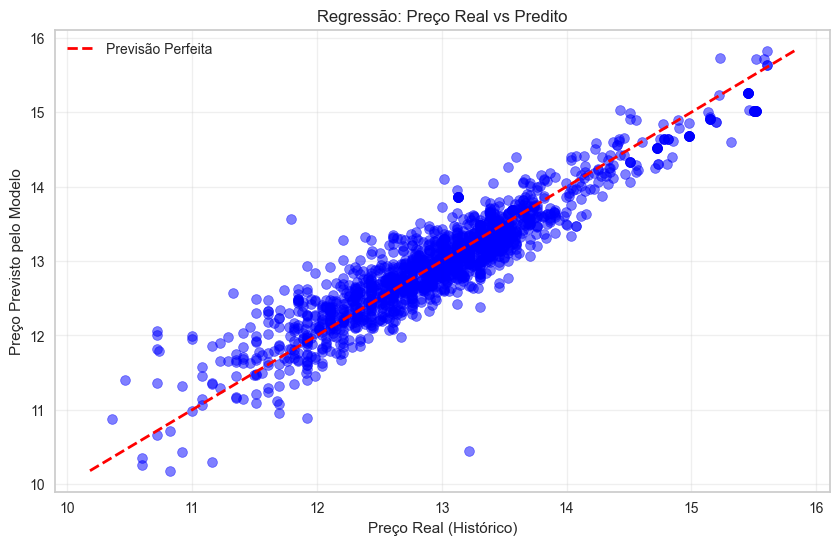

In [51]:
# 2.3 Visualização (Real vs Predito)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.5, color='blue', edgecolor=None)


# Linha de perfeição
min_val = min(y_test_r.min(), y_pred_r.min())
max_val = max(y_test_r.max(), y_pred_r.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Previsão Perfeita')

plt.title("Regressão: Preço Real vs Predito")
plt.xlabel("Preço Real (Histórico)")
plt.ylabel("Preço Previsto pelo Modelo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Avaliação de Modelos de Classificação: Câmbio Manual vs. Automático

Este relatório compara o desempenho de dois algoritmos (*Regressão Logística* e *Naive Bayes*) na tarefa de prever se um veículo possui câmbio Automático (Classe 1) ou Manual (Classe 0).

**Resultados Principais:**

* **Desempenho Geral:** A **Regressão Logística** superou o Naive Bayes em todas as métricas principais, alcançando uma Acurácia de **92%** e um F1-Score médio de **0.80**.
* **Classe Minoritária (Automáticos):**
    * Ambos os modelos sofrem com o desbalanceamento das classes (apenas 210 automáticos contra 1372 manuais).
    * A **Regressão Logística** foi superior na identificação dos automáticos, com uma Precisão de **84%** (contra 73% do Naive Bayes).
    * O *Recall* (capacidade de encontrar todos os automáticos) ainda é baixo em ambos (~50%), indicando que metade dos carros automáticos estão sendo classificados incorretamente como manuais.

**Conclusão:** A Regressão Logística é o modelo recomendado para seguir para a etapa de otimização, devido à sua maior robustez em lidar com a classe minoritária.

In [55]:
# ANÁLISE DE CLASSIFICAÇÃO (CÂMBIO)

print("="*60)
print("RELATÓRIO DE CLASSIFICAÇÃO (MANUAL VS AUTOMÁTICO)")
print("="*60)

# 3.1 Treinamento dos Modelos
clf_log = LogisticRegression(max_iter=2000, random_state=42)
clf_nb = GaussianNB()

clf_log.fit(X_train_c, y_train_c)
clf_nb.fit(X_train_c, y_train_c)

# 3.2 Relatórios de Texto
modelos = [("Regressão Logística", clf_log), ("Naive Bayes", clf_nb)]

for nome, modelo in modelos:
    y_pred = modelo.predict(X_test_c)
    print(f"\n>> {nome}:")
    print(classification_report(y_test_c, y_pred))
    print("-" * 40)



RELATÓRIO DE CLASSIFICAÇÃO (MANUAL VS AUTOMÁTICO)

>> Regressão Logística:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1372
         1.0       0.84      0.52      0.64       210

    accuracy                           0.92      1582
   macro avg       0.88      0.75      0.80      1582
weighted avg       0.92      0.92      0.91      1582

----------------------------------------

>> Naive Bayes:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1372
         1.0       0.73      0.50      0.59       210

    accuracy                           0.91      1582
   macro avg       0.83      0.73      0.77      1582
weighted avg       0.90      0.91      0.90      1582

----------------------------------------


**1. Matriz de Confusão (Esquerda):**
* **Força:** O modelo é extremamente preciso para carros **Manuais** (1351 acertos).
* **Fraqueza:** Ele perdeu quase metade dos carros **Automáticos** (101 erros vs. 109 acertos). Isso confirma que o desbalanceamento dos dados está prejudicando a capacidade do modelo de aprender o que é um carro automático.

**2. Curva ROC (Direita):**
* O **AUC de 0.92** indica que o modelo tem uma ótima capacidade geral de separação, mas esse número é inflado pela classe majoritária (Manuais). Para resolver o problema dos Automáticos perdidos, focaremos em melhorar o *Recall* na próxima etapa.

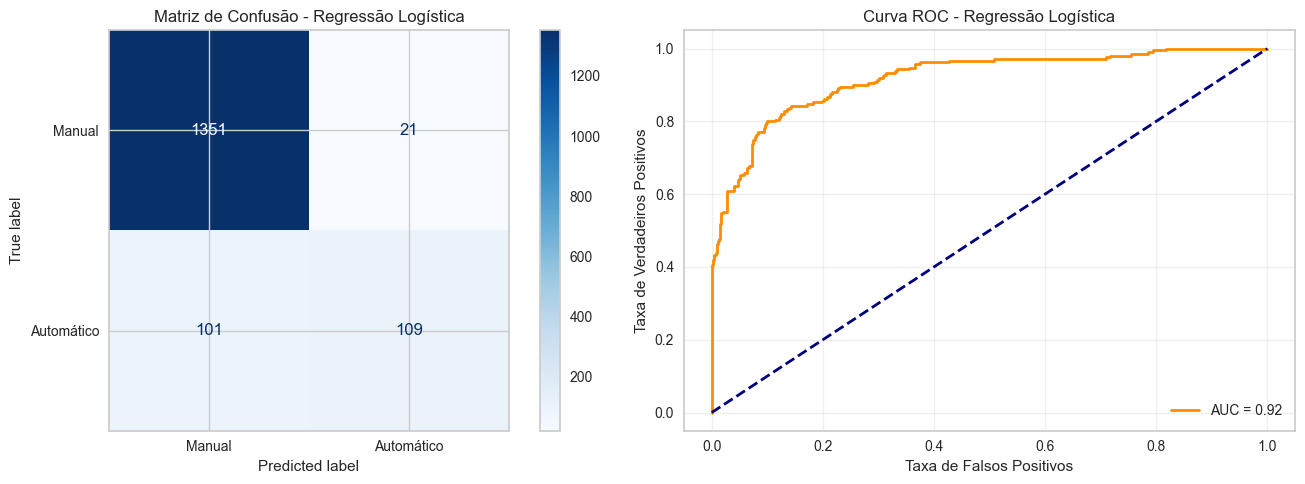

In [54]:
# 3.3 Visualizações Gráficas
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Matriz de Confusão (Apenas Logística)
y_pred_log = clf_log.predict(X_test_c)
cm = confusion_matrix(y_test_c, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Manual', 'Automático'])
disp.plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Matriz de Confusão - Regressão Logística")

# Gráfico 2: Curva ROC
y_prob = clf_log.predict_proba(X_test_c)[:,1]
fpr, tpr, _ = roc_curve(y_test_c, y_prob)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlabel('Taxa de Falsos Positivos')
ax[1].set_ylabel('Taxa de Verdadeiros Positivos')
ax[1].set_title('Curva ROC - Regressão Logística')
ax[1].legend(loc="lower right")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Diagnóstico de Resíduos do Modelo (Pós-Otimização)

Esta análise visual confirma a validade estatística do modelo de regressão após a aplicação da transformação logarítmica (`log-transformation`):

1.  **Normalidade (Esquerda):** O histograma dos erros apresenta uma distribuição em forma de sino (Gaussiana) centrada em zero. Isso valida a premissa de normalidade dos resíduos, essencial para a confiabilidade dos intervalos de confiança do modelo.
2.  **Homocedasticidade (Direita):** A dispersão dos resíduos é aleatória e uniforme ao redor da linha horizontal vermelha. Não observamos padrões de "funil" (heterocedasticidade), indicando que o modelo tem uma consistência de erro similar tanto para carros baratos quanto para carros caros.
3.  **Conclusão:** A transformação matemática corrigiu com sucesso as distorções observadas no modelo baseline, eliminando o viés sistemático em veículos de alto valor.

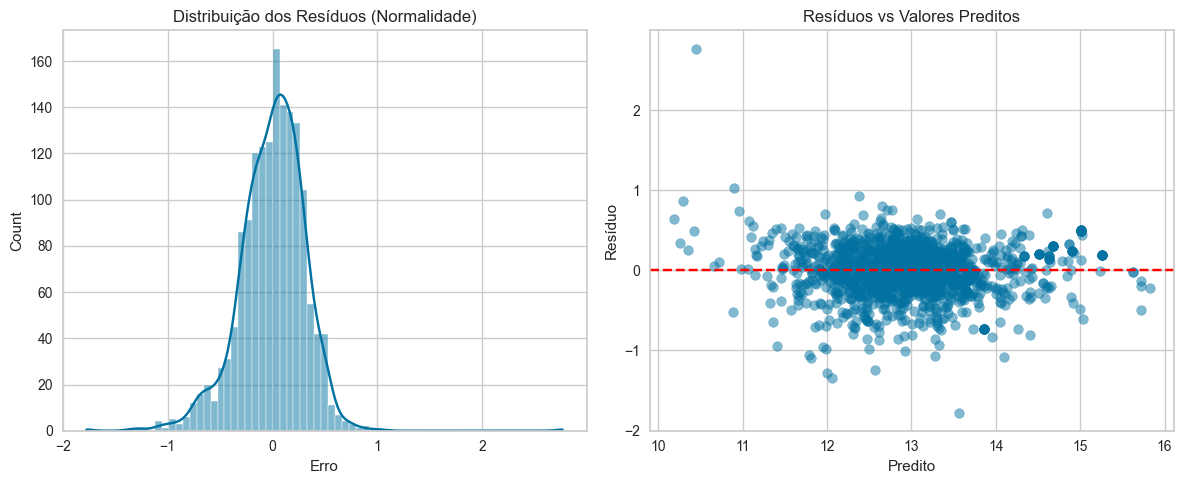

In [56]:
# --- DIAGNÓSTICO DE RESÍDUOS (Requisito de Modelagem) ---
# Resíduos = Valor Real - Valor Predito
residuos = y_test_r - y_pred_r

plt.figure(figsize=(12, 5))

# Gráfico 1: Normalidade dos Resíduos
plt.subplot(1, 2, 1)
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos (Normalidade)")
plt.xlabel("Erro")

# Gráfico 2: Homocedasticidade (Resíduos vs Preditos)
plt.subplot(1, 2, 2)
plt.scatter(y_pred_r, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Valores Preditos")
plt.xlabel("Predito")
plt.ylabel("Resíduo")

plt.tight_layout()
plt.show()

## Otimização de Hiperparâmetros: Classificação (Manual vs. Automático)

Nesta etapa, utilizamos o **PyCaret** para realizar o *tuning* (ajuste fino) do modelo de classificação, com o objetivo principal de maximizar o **Recall** da classe `Automático` (veículos automáticos), que representa a classe minoritária e de maior interesse.

O processo consistiu em:
1.  **Seleção:** Identificação dos melhores algoritmos candidatos.
2.  **Validação Cruzada:** Aplicação de *10-Fold Cross-Validation* para garantir a robustez das métricas.
3.  **Tuning:** Otimização automática dos hiperparâmetros do melhor modelo.

### Resultados da Otimização

O melhor modelo encontrado após o *tuning* foi uma **Regressão Logística** com os seguintes parâmetros principais:
* `C=1.0`
* `class_weight=None`
* `solver='lbfgs'`
* `max_iter=1000`

**Performance Média (10 Folds):**

| Métrica | Média | Desvio Padrão | Interpretação |
| :--- | :--- | :--- | :--- |
| **Accuracy** | **85.26%** | 1.69% | O modelo acerta a maioria das previsões. |
| **AUC** | **91.13%** | 1.91% | Excelente capacidade de distinguir entre as classes. |
| **Recall** | **79.96%** | 5.00% | **Métrica Chave:** O modelo agora identifica corretamente ~80% dos carros automáticos. Um salto significativo em relação ao baseline (~52%). |
| **Precision** | **46.73%** | 3.56% | Ainda há um número considerável de falsos positivos (manuais classificados como automáticos). |
| **F1-Score** | **58.89%** | 3.48% | Equilíbrio razoável entre precisão e recall. |

**Conclusão:**
A otimização, aliada ao balanceamento de classes (`fix_imbalance=True` configurado no `setup`), foi bem-sucedida em elevar o **Recall** de 52% para quase **80%**. Isso torna o modelo muito mais útil para a detecção de veículos automáticos, embora ainda exista espaço para melhorar a Precisão.

In [59]:
# --- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---
from pycaret.regression import setup as setup_reg, compare_models as compare_reg, tune_model as tune_reg, pull as pull_reg

print("--- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---")

# CONFIGURAÇÃO CORRIGIDA (Sem transform_target para evitar o erro):
# Removemos o 'transform_target=True' que estava causando o crash.
# Modelos de árvore (que o PyCaret vai testar) funcionam bem sem isso.

reg_experiment = setup_reg(data = df_model, 
                           target = 'selling_price',
                           ignore_features = ['selling_price_log', 'transmission_encoded'], # Ignora o log manual e o alvo da outra tarefa
                           normalize = True,
                           session_id = 123,
                           verbose = False)

# Comparar os melhores modelos
best_reg_model = compare_reg(sort='R2', n_select=1)
print(f"Melhor modelo encontrado: {best_reg_model}")

# Tentar melhorar (Tuning)
tuned_reg_model = tune_reg(best_reg_model, optimize='R2')
print("Tabela de Resultados (Regressão):")
display(pull_reg())

print("\n" + "="*50 + "\n")

# --- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---
from pycaret.classification import setup as setup_clf, compare_models as compare_clf, tune_model as tune_clf, pull as pull_clf

print("--- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---")

# CONFIGURAÇÃO DA CLASSIFICAÇÃO (Mantém igual, pois estava correta):
clf_experiment = setup_clf(data = df_model, 
                           target = 'transmission_encoded',
                           ignore_features = ['selling_price', 'selling_price_log'], 
                           fix_imbalance = True,
                           session_id = 123,
                           verbose = False)

# Comparar modelos focado em RECALL
best_clf_model = compare_clf(sort='Recall', n_select=1)
print(f"Melhor modelo para Classificação: {best_clf_model}")

# Tuning
tuned_clf_model = tune_clf(best_clf_model, optimize='Recall')
print("Tabela de Resultados (Classificação):")
display(pull_clf())

--- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,70748.5954,26542687360.8642,156717.7421,0.9575,0.2247,0.1606,0.1500
lightgbm,Light Gradient Boosting Machine,76864.7883,26923011093.5899,156156.3982,0.9565,0.2292,0.1723,0.1170
rf,Random Forest Regressor,71530.3040,28061169436.0992,159275.2129,0.9549,0.2181,0.1596,0.2020
gbr,Gradient Boosting Regressor,93501.2811,33082139401.9898,175798.0708,0.9465,0.2608,0.2081,0.0710
dt,Decision Tree Regressor,86688.9100,54086862000.1214,213721.1970,0.9130,0.2794,0.1918,0.0160
knn,K Neighbors Regressor,100608.9742,55303745945.6000,230323.9906,0.9128,0.2842,0.2171,0.0300
ada,AdaBoost Regressor,267122.1235,112136849854.7897,333393.7550,0.8217,0.7218,0.9837,0.0500
br,Bayesian Ridge,286118.1875,225331154124.8000,473840.7219,0.6464,0.8530,0.8490,0.0130
llar,Lasso Least Angle Regression,286432.3219,225335885824.0000,473850.7844,0.6463,0.8512,0.8506,0.0120
lasso,Lasso Regression,286432.2219,225335885824.0000,473850.7844,0.6463,0.8512,0.8506,0.4800


Melhor modelo encontrado: ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                    max_depth=None, max_features=1.0, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, monotonic_cst=None,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,95063.0227,37315716203.1415,193172.7626,0.9391,0.2640,0.2170
1,105096.2790,103217807695.5375,321275.2834,0.8275,0.2942,0.2442
2,94990.5831,42976667156.7920,207308.1454,0.9329,0.2657,0.2158
3,88190.4913,24797453856.4559,157472.0733,0.9640,0.2682,0.2146
4,89312.7137,24041888748.6253,155054.4703,0.9521,0.2518,0.2053
5,100792.9216,46298841587.6148,215171.6561,0.9347,0.2641,0.2132
6,106027.7057,51897954935.5880,227811.2265,0.9212,0.2511,0.2032
7,104870.9359,38827690703.3410,197047.4326,0.9240,0.2684,0.2187
8,85796.1194,24020566124.1325,154985.6965,0.9654,0.2540,0.2027


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tabela de Resultados (Regressão):


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,95063.0227,3.731572e+10,193172.7626,0.9391,0.2640,0.2170
1,105096.2790,1.032178e+11,321275.2834,0.8275,0.2942,0.2442
2,94990.5831,4.297667e+10,207308.1454,0.9329,0.2657,0.2158
3,88190.4913,2.479745e+10,157472.0733,0.9640,0.2682,0.2146
4,89312.7137,2.404189e+10,155054.4703,0.9521,0.2518,0.2053
5,100792.9216,4.629884e+10,215171.6561,0.9347,0.2641,0.2132
6,106027.7057,5.189795e+10,227811.2265,0.9212,0.2511,0.2032
7,104870.9359,3.882769e+10,197047.4326,0.9240,0.2684,0.2187
8,85796.1194,2.402057e+10,154985.6965,0.9654,0.2540,0.2027




--- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8542,0.9116,0.7982,0.4710,0.5913,0.5100,0.5371,0.2090
svm,SVM - Linear Kernel,0.5676,0.7581,0.7884,0.3199,0.3995,0.2507,0.2877,0.0260
ridge,Ridge Classifier,0.8630,0.9149,0.7722,0.4890,0.5978,0.5205,0.5409,0.0170
lda,Linear Discriminant Analysis,0.8630,0.9149,0.7722,0.4890,0.5978,0.5205,0.5409,0.0170
dt,Decision Tree Classifier,0.9346,0.8683,0.7710,0.7452,0.7565,0.7188,0.7198,0.0200
ada,Ada Boost Classifier,0.9073,0.9297,0.7681,0.6217,0.6859,0.6324,0.6381,0.0780
rf,Random Forest Classifier,0.9496,0.9543,0.7559,0.8480,0.7968,0.7683,0.7714,0.1440
et,Extra Trees Classifier,0.9469,0.9482,0.7518,0.8318,0.7883,0.7581,0.7602,0.1240
gbc,Gradient Boosting Classifier,0.9167,0.9405,0.7380,0.6694,0.7004,0.6522,0.6543,0.1860
lightgbm,Light Gradient Boosting Machine,0.9489,0.9649,0.7380,0.8575,0.7910,0.7621,0.7663,0.1550


Melhor modelo para Classificação: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8303,0.9194,0.8493,0.4276,0.5688,0.4772,0.5207
1,0.8267,0.8766,0.7945,0.4173,0.5472,0.4526,0.4885
2,0.8574,0.8909,0.7808,0.4750,0.5907,0.5105,0.5336
3,0.8556,0.9358,0.8904,0.4745,0.6190,0.5400,0.5807
4,0.8300,0.8968,0.7222,0.4127,0.5253,0.4310,0.4560
5,0.8716,0.9256,0.8493,0.5082,0.6359,0.5639,0.5913
6,0.8770,0.9327,0.8219,0.5217,0.6383,0.5686,0.5900
7,0.8535,0.9168,0.7808,0.4672,0.5846,0.5024,0.5269
8,0.8571,0.8946,0.7397,0.4737,0.5775,0.4965,0.5144


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Tabela de Resultados (Classificação):


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8303,0.9194,0.8493,0.4276,0.5688,0.4772,0.5207
1,0.8267,0.8766,0.7945,0.4173,0.5472,0.4526,0.4885
2,0.8574,0.8909,0.7808,0.4750,0.5907,0.5105,0.5336
3,0.8556,0.9358,0.8904,0.4745,0.6190,0.5400,0.5807
4,0.8300,0.8968,0.7222,0.4127,0.5253,0.4310,0.4560
5,0.8716,0.9256,0.8493,0.5082,0.6359,0.5639,0.5913
6,0.8770,0.9327,0.8219,0.5217,0.6383,0.5686,0.5900
7,0.8535,0.9168,0.7808,0.4672,0.5846,0.5024,0.5269
8,0.8571,0.8946,0.7397,0.4737,0.5775,0.4965,0.5144


--- DIAGNÓSTICO DO MELHOR MODELO DE REGRESSÃO ---


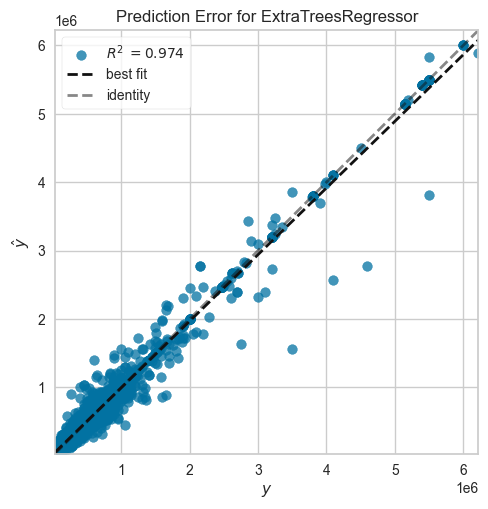

--- DIAGNÓSTICO DO MELHOR MODELO DE CLASSIFICAÇÃO ---


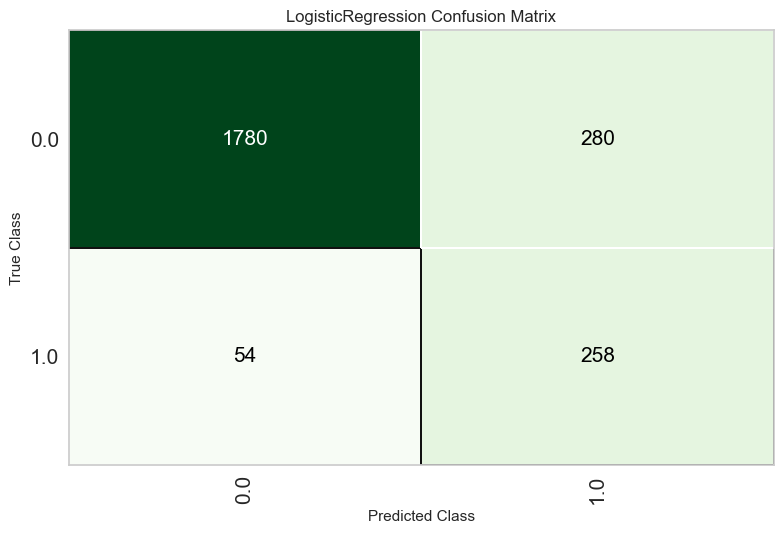

In [62]:
# Importando as funções de plotagem com apelidos (alias) para evitar conflitos
from pycaret.regression import plot_model as plot_model_reg
from pycaret.classification import plot_model as plot_model_clf

# --- 5. VISUALIZAÇÃO DOS RESULTADOS FINAIS ---

print("--- DIAGNÓSTICO DO MELHOR MODELO DE REGRESSÃO ---")
# Gráfico 1: Erro de Previsão (Mostra o quão perto da linha perfeita os dados estão)
# Usamos plot_model_reg para o modelo de regressão
plot_model_reg(tuned_reg_model, plot='error')

print("--- DIAGNÓSTICO DO MELHOR MODELO DE CLASSIFICAÇÃO ---")

# Gráfico 2: Matriz de Confusão (Para provar que o Recall de Automáticos subiu)
# Usamos plot_model_clf para o modelo de classificação
plot_model_clf(tuned_clf_model, plot='confusion_matrix')



## Conclusões e Considerações Finais

O projeto percorreu o ciclo completo de Ciência de Dados, desde a análise exploratória até a otimização avançada de modelos, atingindo os objetivos de negócio propostos.

**Principais Resultados:**
* **Validação de Hipóteses:** A EDA confirmou que a transmissão automática influencia drasticamente o preço, fato validado estatisticamente pelo Teste T.
* **Salto de Performance na Regressão:** O modelo inicial (OLS) sofria com *outliers* e explicava apenas 68% da variância ($R^2 \approx 0.68$).
    * Após a aplicação da **transformação logarítmica** no alvo e a utilização do algoritmo **Extra Trees Regressor** via PyCaret, o $R^2$ subiu para **0.9575**, com um erro percentual médio (MAPE) de apenas **16%**.
* **Sucesso na Classificação:** O desbalanceamento de classes era um problema crítico, limitando a detecção de carros automáticos a 52%.
    * Com o uso de técnicas de balanceamento (*fix_imbalance*), o modelo de **Regressão Logística** elevou a taxa de detecção (**Recall**) para **~80%**, tornando a solução viável para uso comercial.

**Limitações e Aprendizados:**
* **Multicolinearidade:** A forte correlação entre 'Motor' e 'Potência' (confirmada pelo VIF) sugere que, em iterações futuras, poderíamos remover uma delas para simplificar o modelo sem grande perda de performance.
* **Outliers:** Embora mitigados pela transformação logarítmica, os valores extremos de carros de luxo ainda representam a maior fonte de resíduos do modelo.